# Sample Assessment Geo Data Science

## Abstract

Over the last years, remote sensing has developed satellite sensors to collect high spatial and temporal resolution images from Earth's surface generating large data and new opportunities for developing methods to access and analyse this data, as Earth observation data cubes. With data cubes it is possible to analyse the Earth's surface over temporal and spatial attributes and allows the extraction of Land Use and Land Cover (LULC) features and patterns to map land use changes. This also provides an extensive mass of historical data about phenology and years of image time series [[1]](./README.md#References). Soon, this historical data can be useful for training deep learning algorithms based on temporal and spatial dimensions. The paper [[1]](./README.md#References) demonstrated how this historical data can be used to generate LULC samples using Time-Weighted Dynamic Time Warping (TWDTW). As demonstrated in [[2]](./README.md#References) the current ways to classify land use and land cover maps like Random Forest and Support Vector Machines (SVM) algorithms have been successfully applied to the LULC change classification. However these algorithms do not use the temporal dimension, an important characteristic in data cubes, in the classification process, resulting in lost data. In other words, the order of the images does not influence the results. The approach presented by the paper [[2]](./README.md#References) proposed a comprehensive study of Temporal Convolutional Neural Networks (TempCNNs), an in-depth approach that applies convolutions in the temporal dimension to automatically learn temporal and spectral features. The study presented by [[3]](./README.md#References) demonstrates the good quality of TempCNN to accurately map LULC without over-representation of majority classes using TempCNN. This approach aims to present a study about remote sensing time series features extraction using TempCNN to LULC classification to estimate the probability of LULC class based on deep learning algorithms in order to contribute to LULC sample generation over the Brazilian Biomes territory. This approach will use the Brazil Data Cube infrastructure to collect data and analyse them. To estimate the probability of LULC classes, this study will use an active learning method, a stored model that will predict the class of unlabeled data based on labeled data and stored, as an oracle. This study also seeks to demonstrate a comparison between the temporal based Neural Networks as TempCNN, non-temporal based like CNN and the current methods as the Random Forest and SVM Algorithm.

**Aprendizado por Reforço**

In [2]:
source("./R/utils.R")
citation("sits")


To cite SITS in publications use:

  Rolf Simoes, Gilberto Camara, Felipe Souza, Pedro Andrade, Lorena
  Santos, Karine Ferreira, Gilberto Queiroz, Alexandre Carvalho, Victor
  Maus (2021), SITS: Data Analysis and Machine Learning using Satellite
  Image Time Series. URL https://github.com/e-sensing/sits.

A BibTeX entry for LaTeX users is

  @Manual{,
    title = {sits: Data Analysis and Machine Learning using Satellite Image Time Series},
    author = {Rolf Simoes and Gilberto Camara and Felipe Souza and Pedro Andrade and Lorena Santos and Karine Ferreira and Gilberto Queiroz and Alexandre Ywata {de Carvalho} and Victor Maus},
    organization = {INPE - Brazilian National Institute for Space Research},
    address = {Sao Jose dos Campos, Brazil},
    year = {2021},
    url = {https://github.com/e-sensing/sits},
  }


In [3]:
samples <- read_file.tb("./data/samples/samples_amazonia_sentinel2.rda", "rda")
samples <- dplyr::mutate(samples, sample_id = seq_len(nrow(samples)), .before = 1)
head(samples %>% dplyr::select(-time_series))

sample_id,longitude,latitude,start_date,end_date,label,cube
<int>,<dbl>,<dbl>,<date>,<date>,<chr>,<chr>
1,-64.69448,-9.986312,2018-07-28,2019-07-28,Deforestation,sentinel-077095
2,-64.62979,-9.996668,2018-07-28,2019-07-28,Deforestation,sentinel-077095
3,-64.52163,-9.979772,2018-07-28,2019-07-28,Deforestation,sentinel-077095
4,-64.52049,-10.003682,2018-07-28,2019-07-28,Deforestation,sentinel-077095
5,-64.70766,-10.061506,2018-07-28,2019-07-28,Deforestation,sentinel-077095
6,-64.48304,-10.058156,2018-07-28,2019-07-28,Deforestation,sentinel-077095


In [4]:
data_ <- dplyr::filter(samples, label != "NatNonForest")
data_n_forest <- dplyr::filter(samples, label == "NatNonForest")
data_n_forest$label <- "NonForest"
samples <- rbind(data_, data_n_forest)
head(samples %>% dplyr::select(-time_series))

sample_id,longitude,latitude,start_date,end_date,label,cube
<int>,<dbl>,<dbl>,<date>,<date>,<chr>,<chr>
1,-64.69448,-9.986312,2018-07-28,2019-07-28,Deforestation,sentinel-077095
2,-64.62979,-9.996668,2018-07-28,2019-07-28,Deforestation,sentinel-077095
3,-64.52163,-9.979772,2018-07-28,2019-07-28,Deforestation,sentinel-077095
4,-64.52049,-10.003682,2018-07-28,2019-07-28,Deforestation,sentinel-077095
5,-64.70766,-10.061506,2018-07-28,2019-07-28,Deforestation,sentinel-077095
6,-64.48304,-10.058156,2018-07-28,2019-07-28,Deforestation,sentinel-077095


In [7]:
summary <- sits_labels_summary(samples)
colors <- c()
for (i in 1:nrow(summary)) {
    label <- summary[i, ]$label
    colors <- append(colors, color.label(label))
}
labels_summary <- dplyr::mutate(summary, percent = prop, color = colors) %>%
    dplyr::select(-prop) %>% data.frame()
labels_summary <- labels_summary[order(labels_summary$percent, decreasing = TRUE),]
labels_summary

,label,count,percent,color
,<chr>,<int>,<dbl>,<chr>
4,Pasture,460,0.3826955,#ff8828
2,Forest,414,0.3444260,#005500
3,NonForest,171,0.1422629,#0fc80f
1,Deforestation,157,0.1306156,#ff5f4c


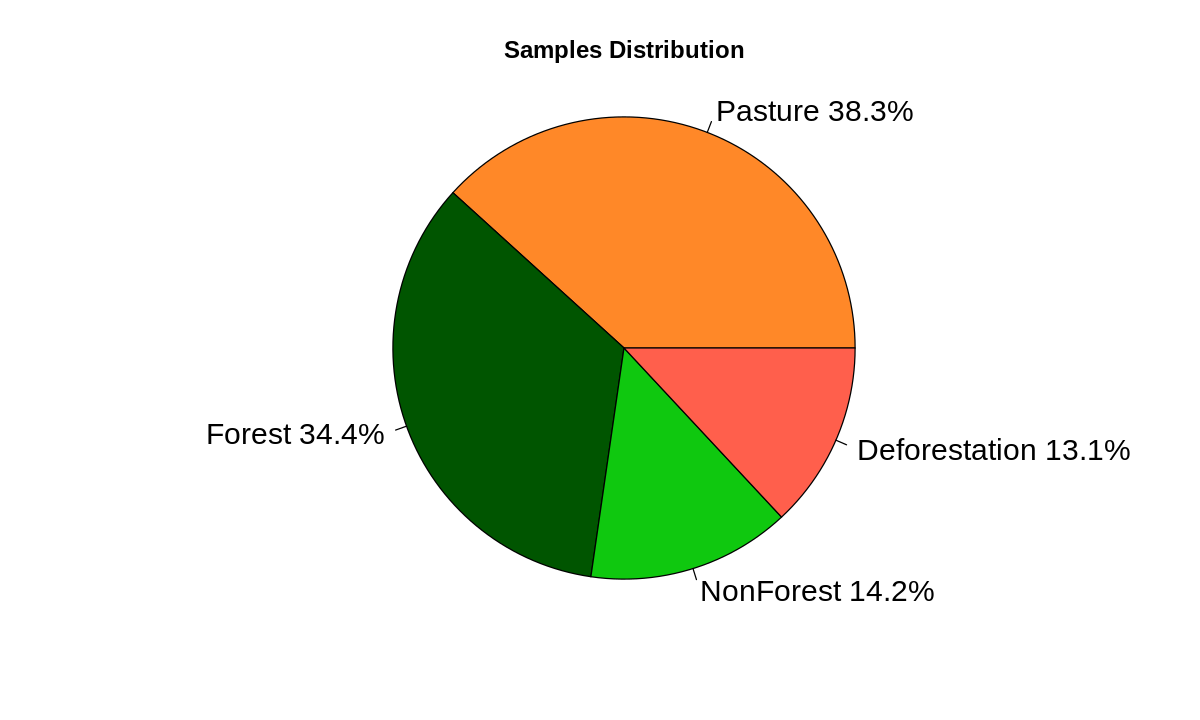

In [8]:
options(repr.plot.width = 10, repr.plot.height = 6)
pie(
    labels_summary$percent,
    paste(labels_summary$label, " ", round(labels_summary$percent * 100, 1), "%", sep=""),
    col = labels_summary$color,
    main = "Samples Distribution",
    cex = 1.5,
    radius = 1
)

In [16]:
bbox <- cbind(longitude = samples$longitude, latitude = samples$latitude) %>%
    SpatialPoints() %>%
        bbox()
bbox

,min,max
longitude,-65.27259,-63.69919
latitude,-10.96711,-9.95304


In [17]:
roi <-  c(
    lon_min = as_tibble(bbox)$min[[1]],
    lon_max = as_tibble(bbox)$max[[1]],
    lat_min = as_tibble(bbox)$min[[2]],
    lat_max = as_tibble(bbox)$max[[2]]
)
roi

lon_min   lon_max   lat_min   lat_max 
-65.27259 -63.69919 -10.96711  -9.95304

In [18]:
bbox_shape <- list(
    longitude = c(roi[["lon_min"]], roi[["lon_max"]]),
    latitude = c(roi[["lat_min"]], roi[["lat_max"]])
) %>% as.data.frame()
bbox_shape

longitude,latitude
<dbl>,<dbl>
-65.27259,-10.96711
-63.69919,-9.95304


In [19]:
shape <- point_to_shape_sp(data.tb = samples)
leaflet(shape, options = leafletOptions(minZoom = 0, maxZoom = 100)) %>%
    addProviderTiles('Esri.WorldImagery') %>%
        addRectangles(
            lng1 = bbox_shape$longitude[[1]], bbox_shape$latitude[[1]],
            lng2 = bbox_shape$longitude[[2]], bbox_shape$latitude[[2]],
            fillColor = "transparent",
            popup = "Bounding Box") %>%
            addCircleMarkers(
                ~longitude, ~latitude,
                fillOpacity = 1,
                fillColor = ~color,
                stroke = F,
                radius = 5,
                popup = ~as.character(
                    paste("Class '", label,
                          "' #id", sample_id, "|",
                          format(
                              as.Date(start_date),
                              format = "Start %Y-%m-%d"
                          ),
                          format(
                              as.Date(end_date),
                              format = "End %Y-%m-%d"
                          )
                )))

Error : Problem with `filter()` input `..1`.
ℹ Input `..1` is `(as.Date(start_date) <= as.Date(date)) & (as.Date(date) <= as.Date(end_date))`.
✖ argument "date" is missing, with no default
Error : Can't subset columns that don't exist.
✖ Column `id_neuron` doesn't exist.
Error : Problem with `filter()` input `..1`.
ℹ Input `..1` is `label == class_label`.
✖ argument "class_label" is missing, with no default


HTML widgets cannot be represented in plain text (need html)

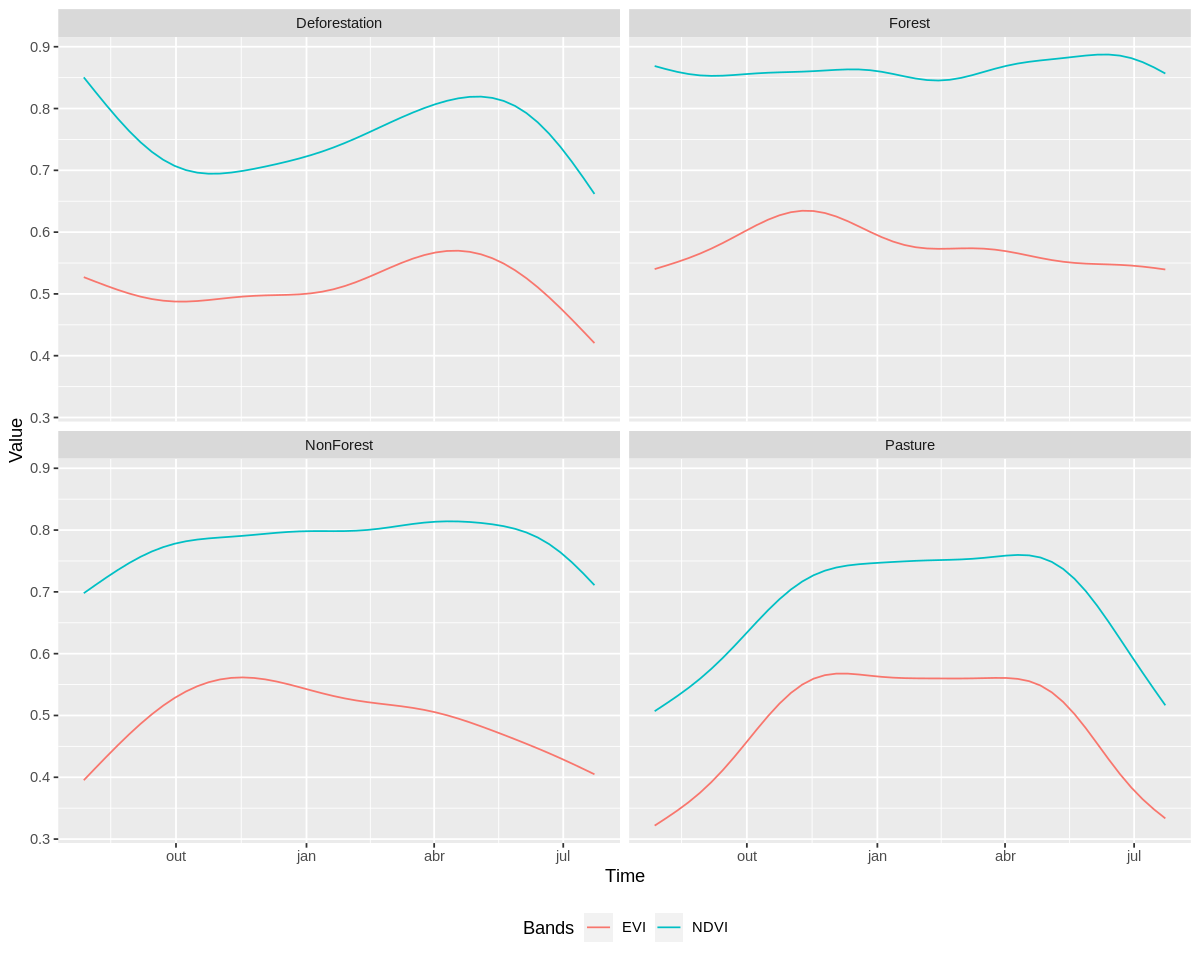

In [20]:
options(repr.plot.width = 10, repr.plot.height = 8)
plot(sits_patterns(sits_select(samples, bands = c("NDVI", "EVI"))))

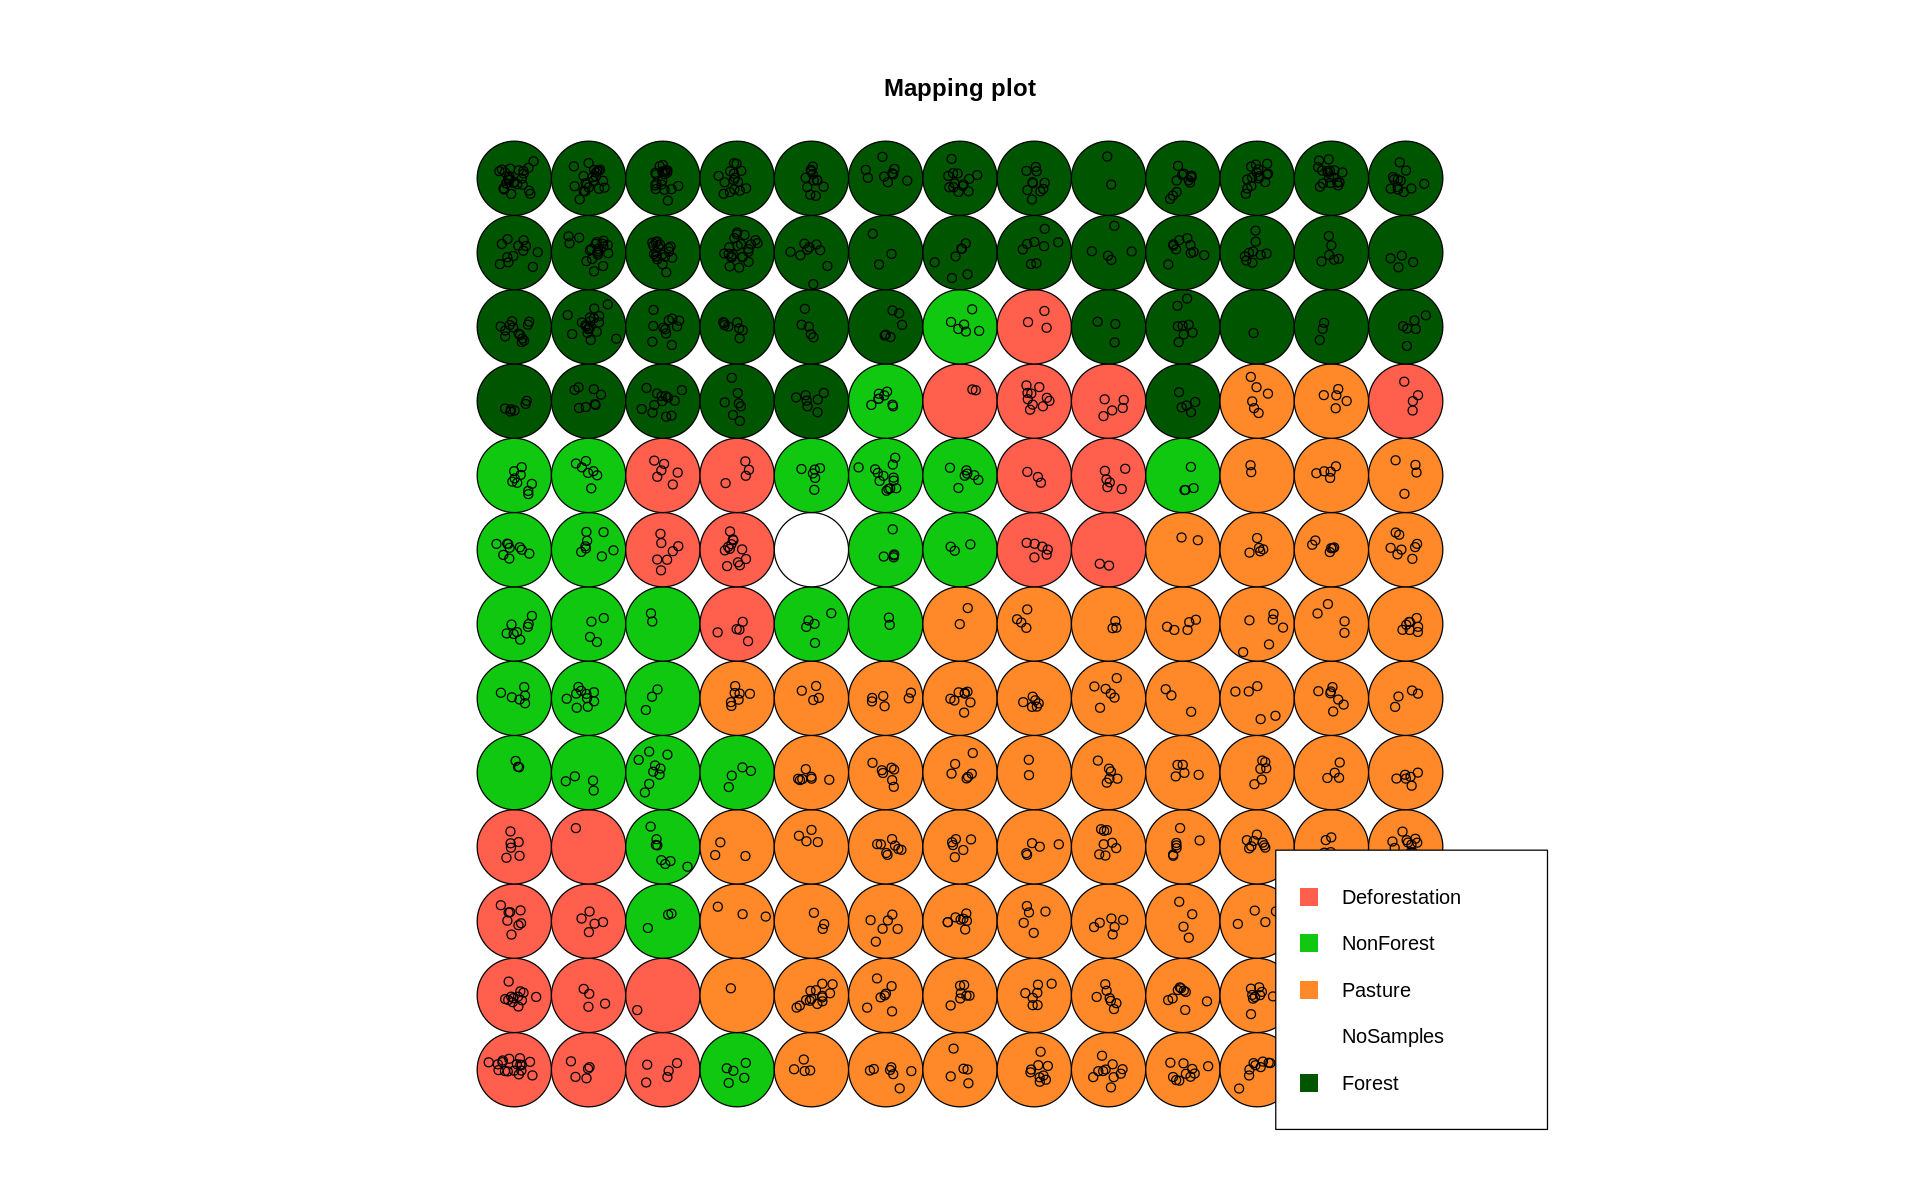

In [22]:
set.seed(775)
size_grid <- as.integer(sqrt(5 * sqrt(length(samples$label))))
clustering.lst <- sits::sits_som_map(
    samples,
    grid_xdim = size_grid,
    grid_ydim = size_grid,
    alpha = c(0.5, 0.01),
    distance = "euclidean",
    rlen = 100,
    som_radius = 1
)
options(repr.plot.width = 16, repr.plot.height = 10)
clustering.lst <- to.color(clustering.lst)
plot(clustering.lst, type = "mapping")

Joining, by = "id_neuron"



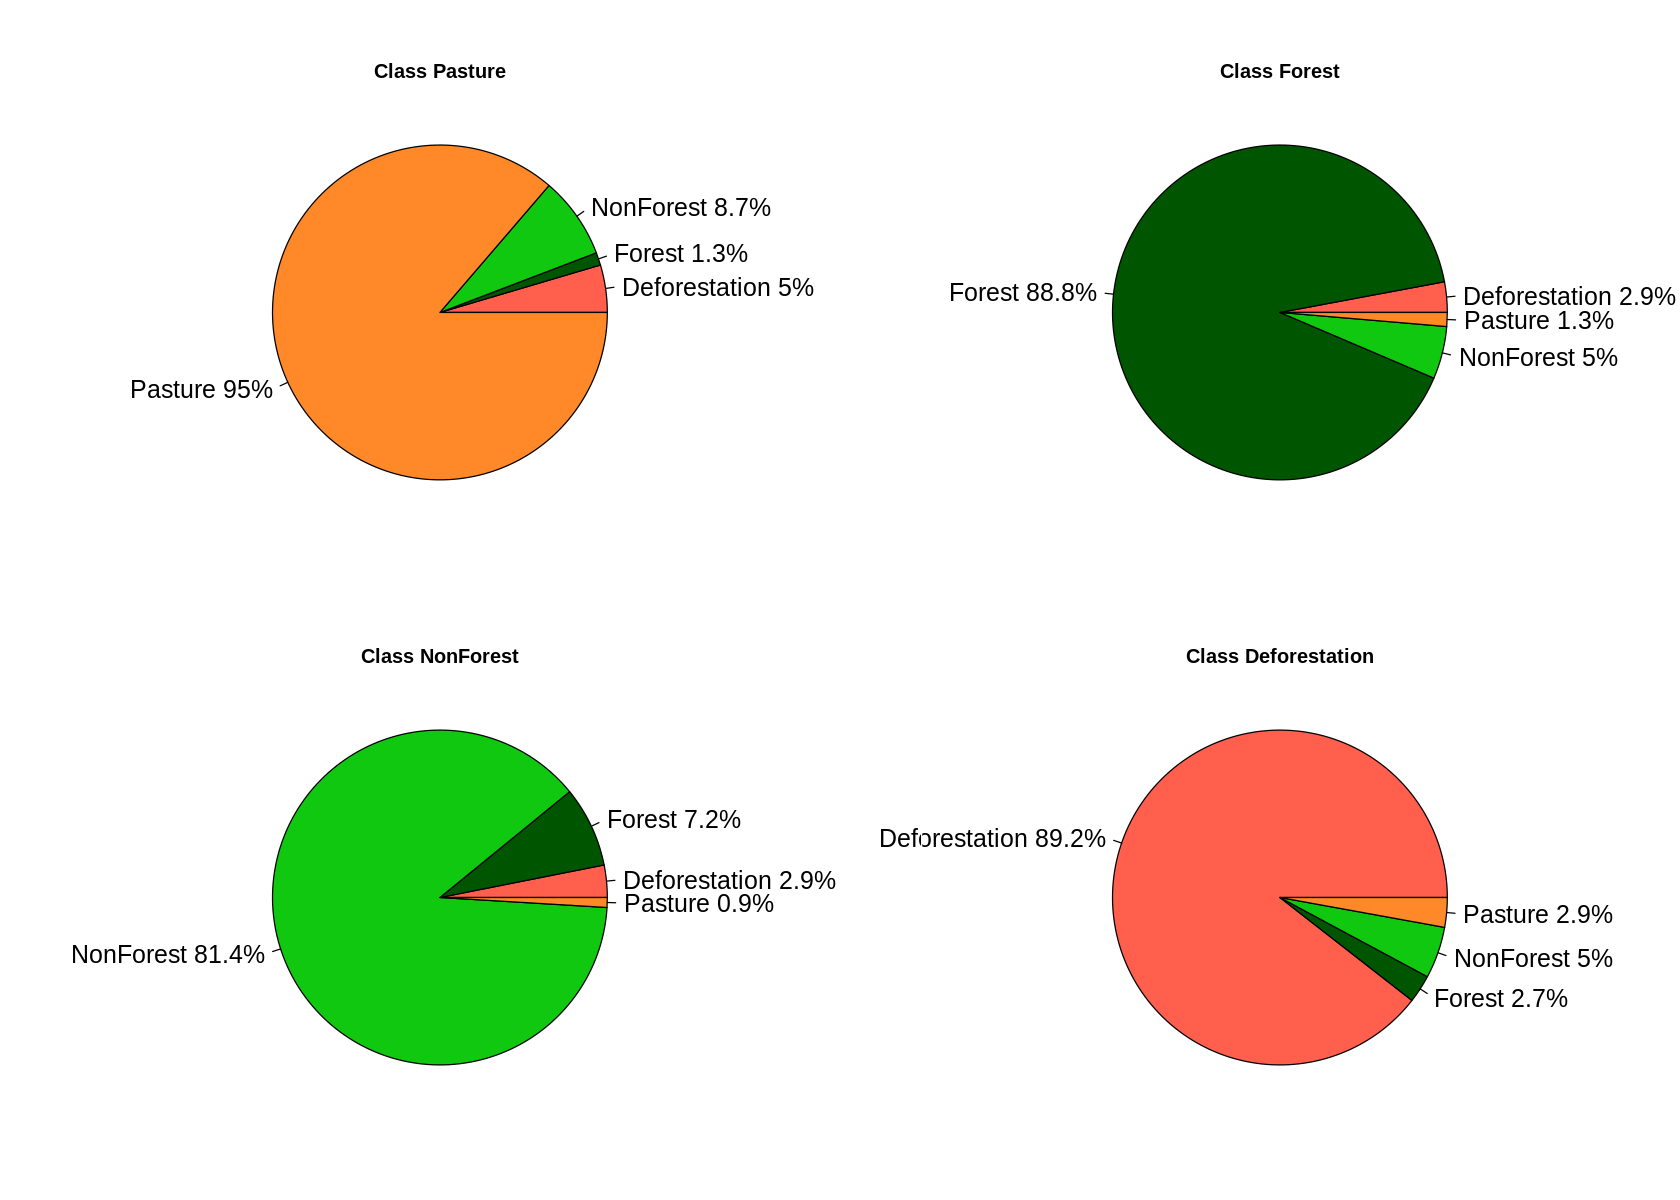

In [24]:
cluster_mixture <- sits_som_evaluate_cluster(clustering.lst)
options(repr.plot.width = 14, repr.plot.height = 10)
par(mfrow = c(2,2), oma = c(0,0,1.5,0), tck = 0)
for (i in 1:nrow(labels_summary)) {
    filtered <- dplyr::filter(cluster_mixture, class == labels_summary[i, ]$label)
    colors <- c()
    for (i in 1:length(filtered$cluster)) {
        colors <- append(colors, color.label(filtered$cluster[[i]]))
    }
    mutation_ <- dplyr::mutate(filtered, color = colors)
    pie(
        mutation_$mixture_percentage,
        paste(mutation_$cluster, " ", round(mutation_$mixture_percentage, 1), "%", sep=""),
        col = mutation_$color,
        main = paste("Class", mutation_$class[[1]]),
        cex = 1.5,
        radius = 0.9
    )
}
box(col = "white")

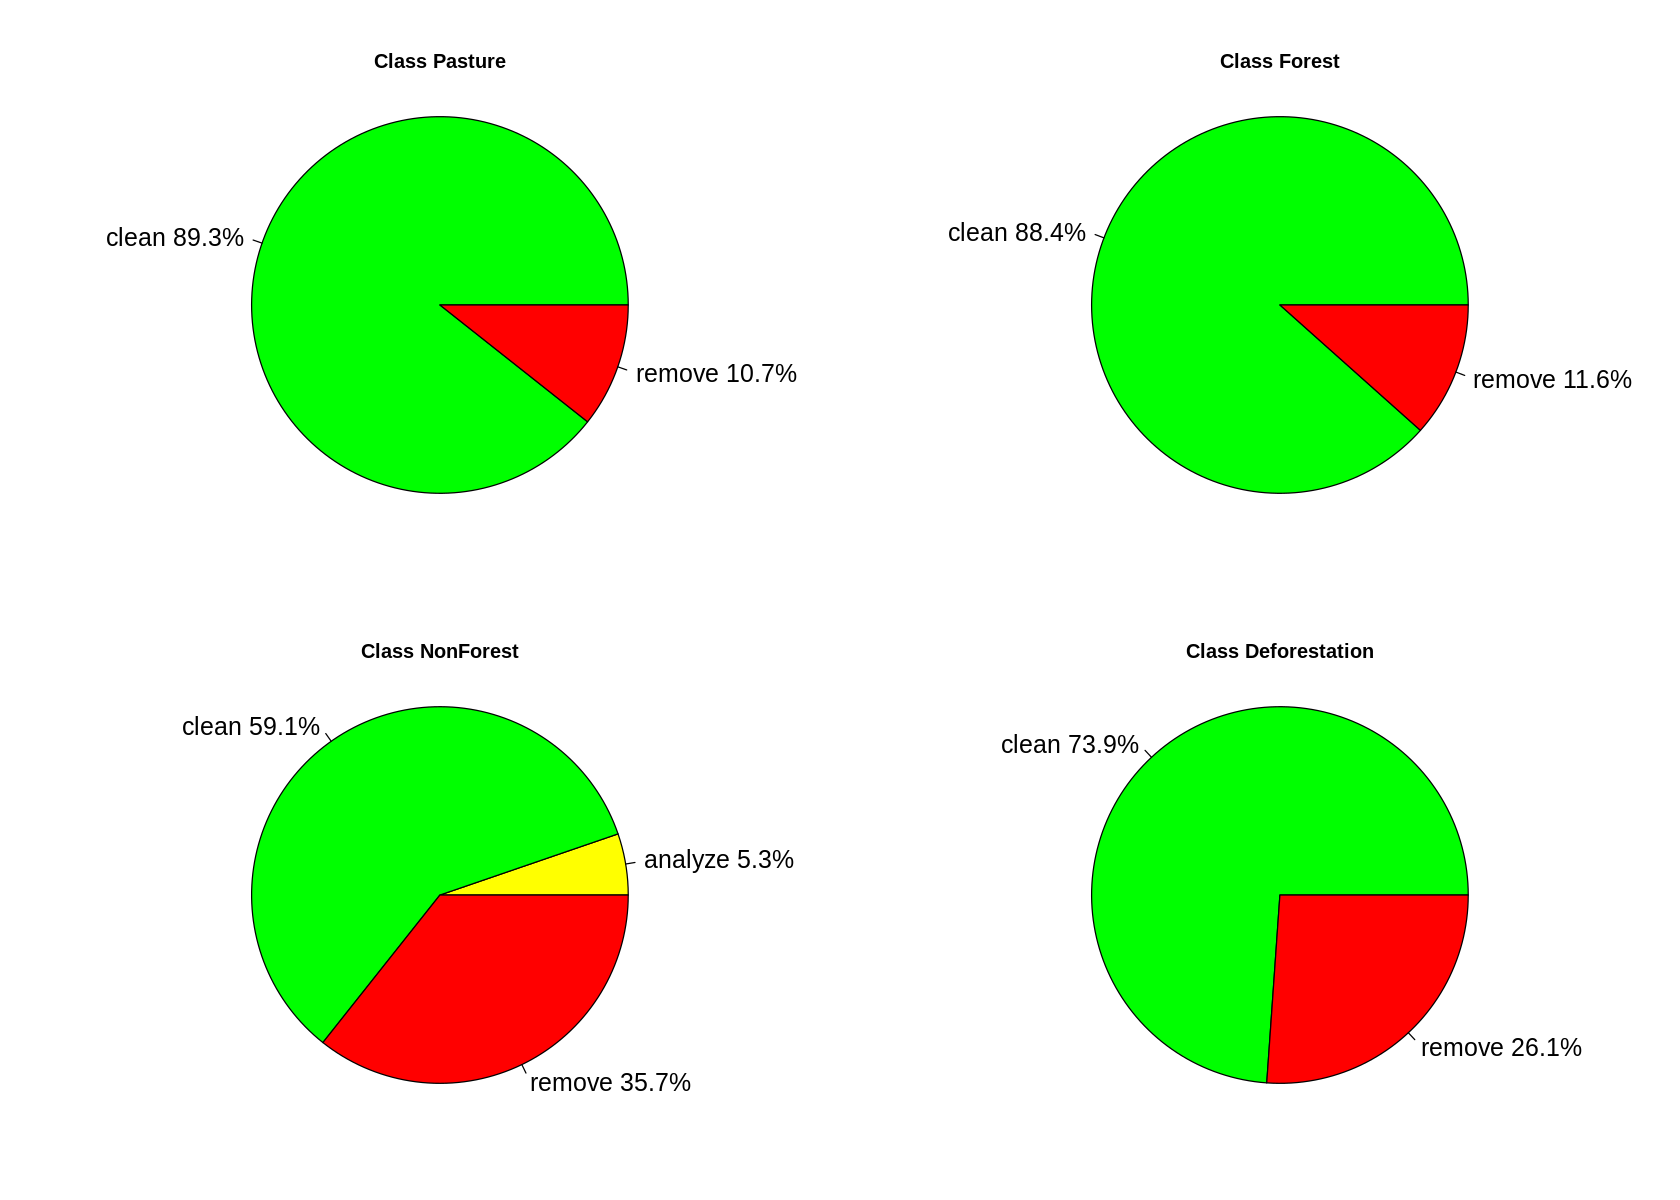

In [26]:
samples_quality <- sits_som_clean_samples(
    clustering.lst,
    prior_threshold = 0.7,
    posterior_threshold = 0.5,
    keep = c("clean", "analyze","remove")
)
group <- dplyr::group_by(samples_quality, label, eval)
agregation <- dplyr::summarise(group, n = n(), .groups = "drop_last")
options(repr.plot.width = 14, repr.plot.height = 10)
par(mfrow = c(2,2), oma = c(0,0,1,0), tck = 0)
for (i in 1:nrow(labels_summary)) {
    filtered <- dplyr::filter(agregation, label == labels_summary[i, ]$label)
    colors <- c()
    for (i in 1:length(filtered$eval)) {
        colors <- append(colors, color.label(filtered$eval[[i]]))
    }
    mutation_ <- dplyr::mutate(filtered, percent = n/sum(n), color = colors)
    pie(
        mutation_$percent,
        paste(mutation_$eval, " ", round(mutation_$percent * 100, 1), "%", sep=""),
        col = mutation_$color,
        main = paste("Class", mutation_$label[[1]]),
        cex = 1.5,
        radius = 1
    )
}
box(col = "white")

In [66]:
samples_filtered <- sits_whittaker(
    samples,
    lambda = 0.4,
    bands_suffix = ""
) %>% get_train_test_set(prop = 0.7)
print(paste("Trainig data set =", nrow(samples_filtered$train), "samples"))
print(paste("Testing data set =", nrow(samples_filtered$test), "samples"))

[1] "Trainig data set = 841 samples"
[1] "Testing data set = 361 samples"


In [83]:
n_samples_per_label <- 4

all_data <- rbind(samples_filtered$train, samples_filtered$test)
train_ <- as.data.frame(list())
for (label_ in labels_summary$label) {
    data_ <- samples_quality %>%
        dplyr::filter(label == label_ & eval == "clean")
    data_ <- data_[
      with(data_, order(data_$post_prob, decreasing = TRUE)),
    ]
    data_ <- dplyr::select(head(data_, n_samples_per_label), -id_sample, -id_neuron, -post_prob, -eval)
    data_ <- dplyr::filter(all_data, (sample_id %in% data_$sample_id))    
    train_ <- rbind(train_, data_)
}
# train_ <- sits_random_samples(train_, n_samples_per_label, labels_summary$label)
test_ <- dplyr::filter(all_data, !(sample_id %in% train_$sample_id)) 
#     %>% dplyr::mutate(label = "unknown")
dplyr::select(train_, -time_series)

sample_id,longitude,latitude,start_date,end_date,label,cube
<int>,<dbl>,<dbl>,<date>,<date>,<chr>,<chr>
504,-64.71913,-10.39272,2018-07-28,2019-07-28,Pasture,sentinel-077095
497,-64.72437,-10.39109,2018-07-28,2019-07-28,Pasture,sentinel-077095
490,-64.68766,-10.29669,2018-07-28,2019-07-28,Pasture,sentinel-077095
500,-64.62057,-10.32237,2018-07-28,2019-07-28,Pasture,sentinel-077095
122,-64.49108,-10.17623,2018-07-28,2019-07-28,Forest,sentinel-077095
179,-64.37954,-10.02678,2018-07-28,2019-07-28,Forest,sentinel-077095
137,-64.46487,-10.07407,2018-07-28,2019-07-28,Forest,sentinel-077095
107,-64.47596,-10.00719,2018-07-28,2019-07-28,Forest,sentinel-077095
430,-63.80867,-10.75800,2018-07-28,2019-07-28,NonForest,sentinel-077095


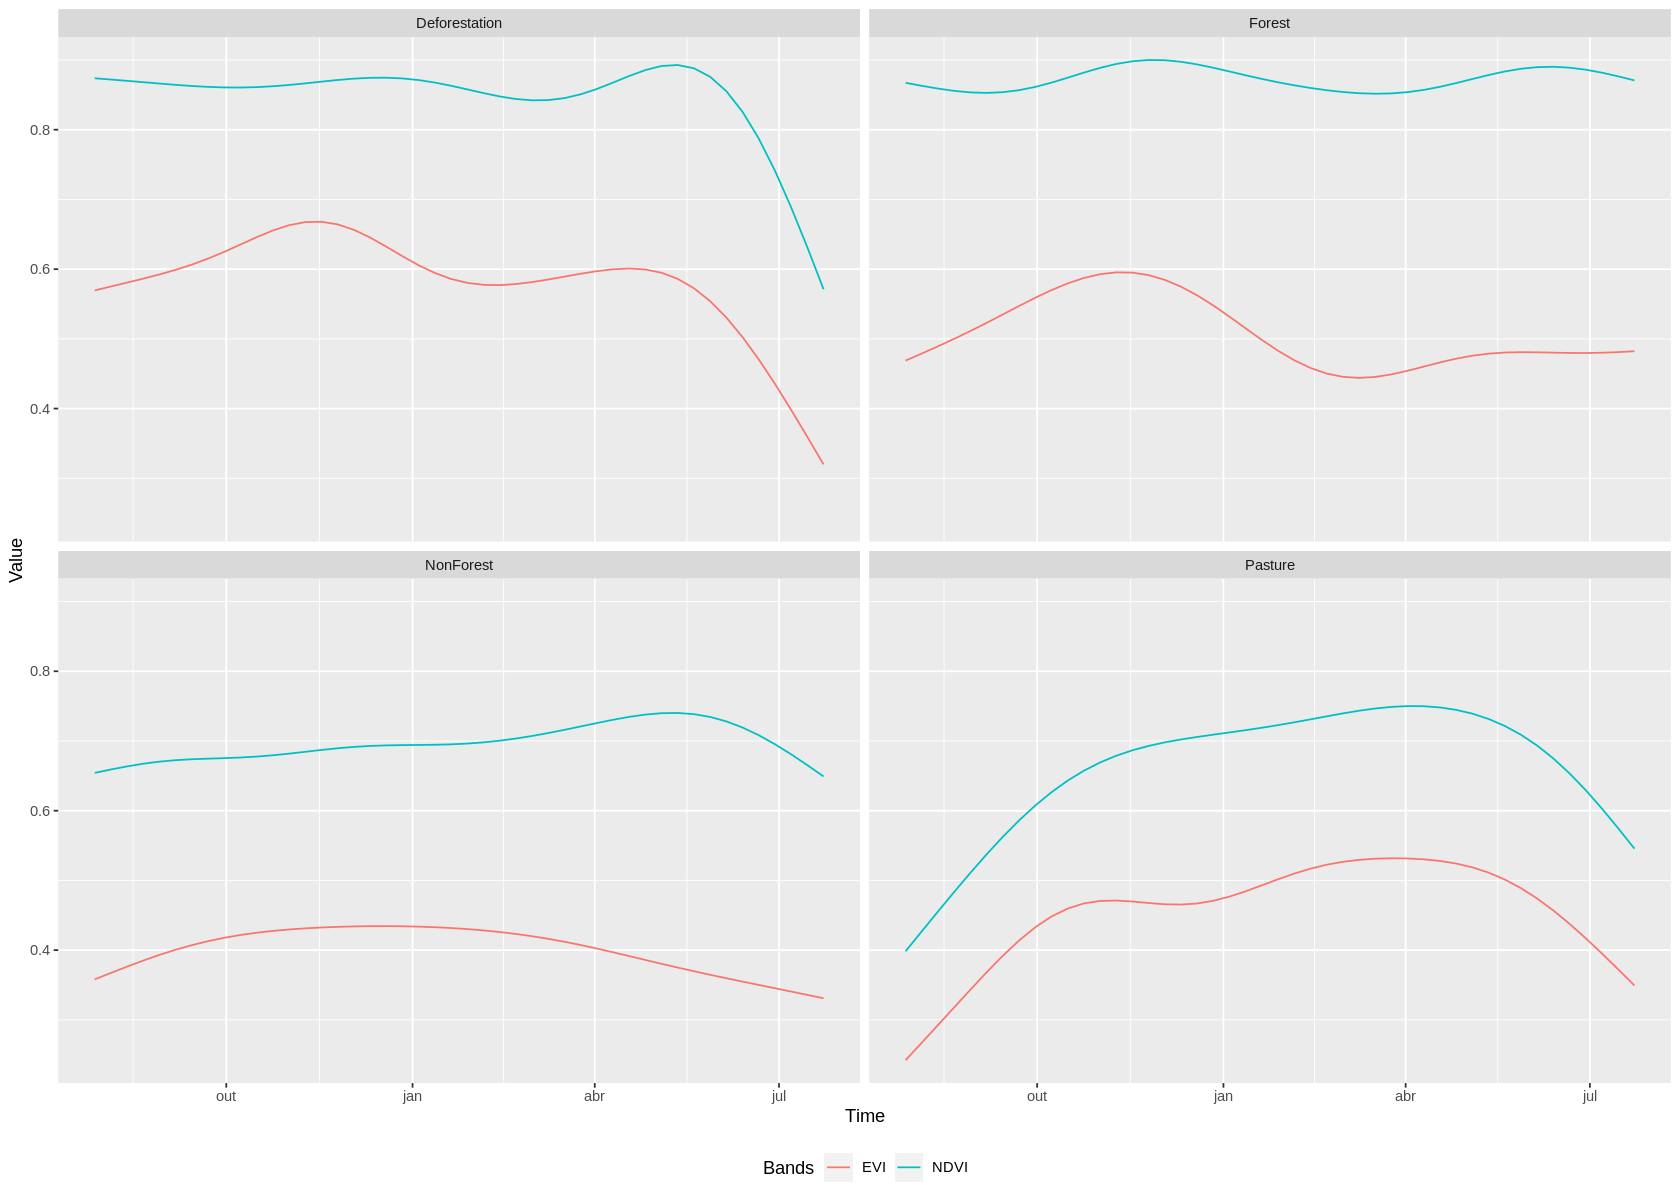

In [69]:
options(repr.plot.width = 14, repr.plot.height = 10)
plot(train_ %>% sits_select(bands = c("NDVI", "EVI")) %>% sits_patterns())

In [52]:
sits_method <- sits_TempCNN(
    cnn_layers = c(64, 64, 64),
    cnn_kernels = c(8, 8, 8),
    cnn_activation = 'relu',
    cnn_L2_rate = 1e-06,
    cnn_dropout_rates = c(0.8, 0.8, 0.8),
    epochs = 100,
    batch_size = 64,
    validation_split = 0.2,
    verbose = 3,
    optimizer = keras::optimizer_adam()
)

In [70]:
# train a machine learning model using tempCNN
# Modificar os parâmetros da rede para a ResNET
# tCNN_model <- sits_train(train, arch)
tCNN_model <- sits_train(train_, sits_method)

`geom_smooth()` using formula 'y ~ x'



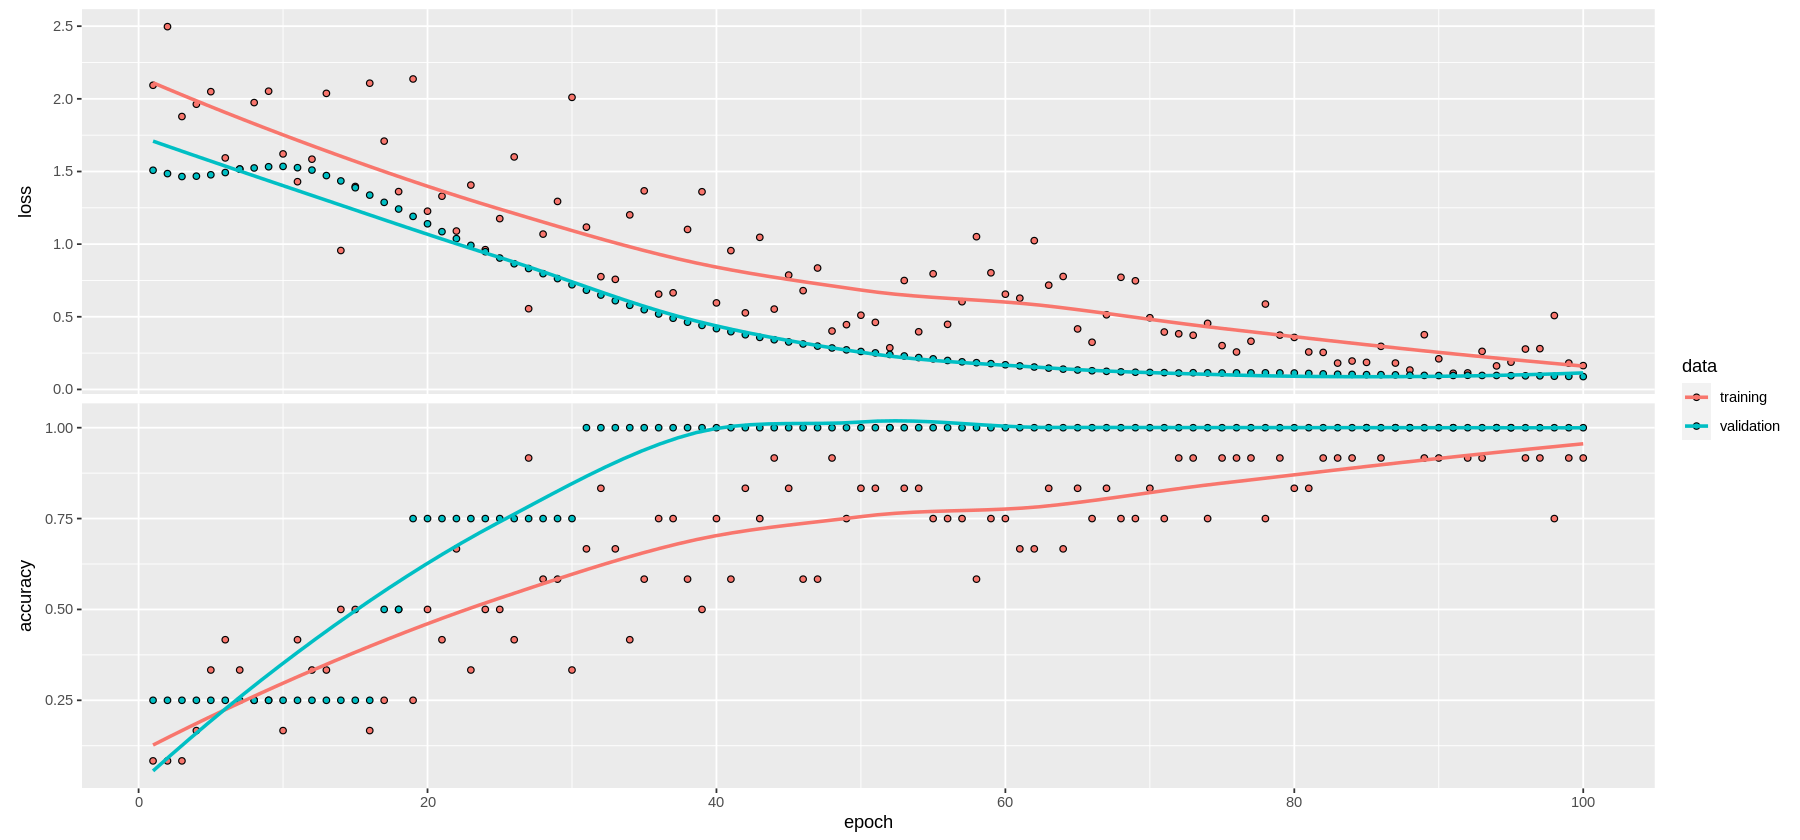

In [71]:
options(repr.plot.width = 15, repr.plot.height = 7)
plot(tCNN_model)

In [135]:
# Classify using TempCNN model and plot the result
sample_test_ <- random_samples(test_, n_samples_per_label * 5)
class <- sample_test_ %>% sits_classify(tCNN_model)
results <- sits_accuracy(class)
results

Confusion Matrix and Statistics

               Reference
Prediction      Deforestation Forest Pasture NonForest
  Deforestation             3      8       1         1
  Forest                    0      2       0         0
  Pasture                   1      0       3         0
  NonForest                 0      0       0         1

Overall Statistics
                            
 Accuracy : 0.45            
   95% CI : (0.2306, 0.6847)
                            
    Kappa : 0.2903          

Statistics by Class:

                          Class: Deforestation Class: Forest Class: Pasture
Prod Acc (Sensitivity)                  0.7500        0.2000         0.7500
Specificity                             0.3750        1.0000         0.9375
User Acc (Pos Pred Value)               0.2308        1.0000         0.7500
Neg Pred Value                          0.8571        0.5556         0.9375
                          Class: NonForest
Prod Acc (Sensitivity)              0.5000
Specificity  

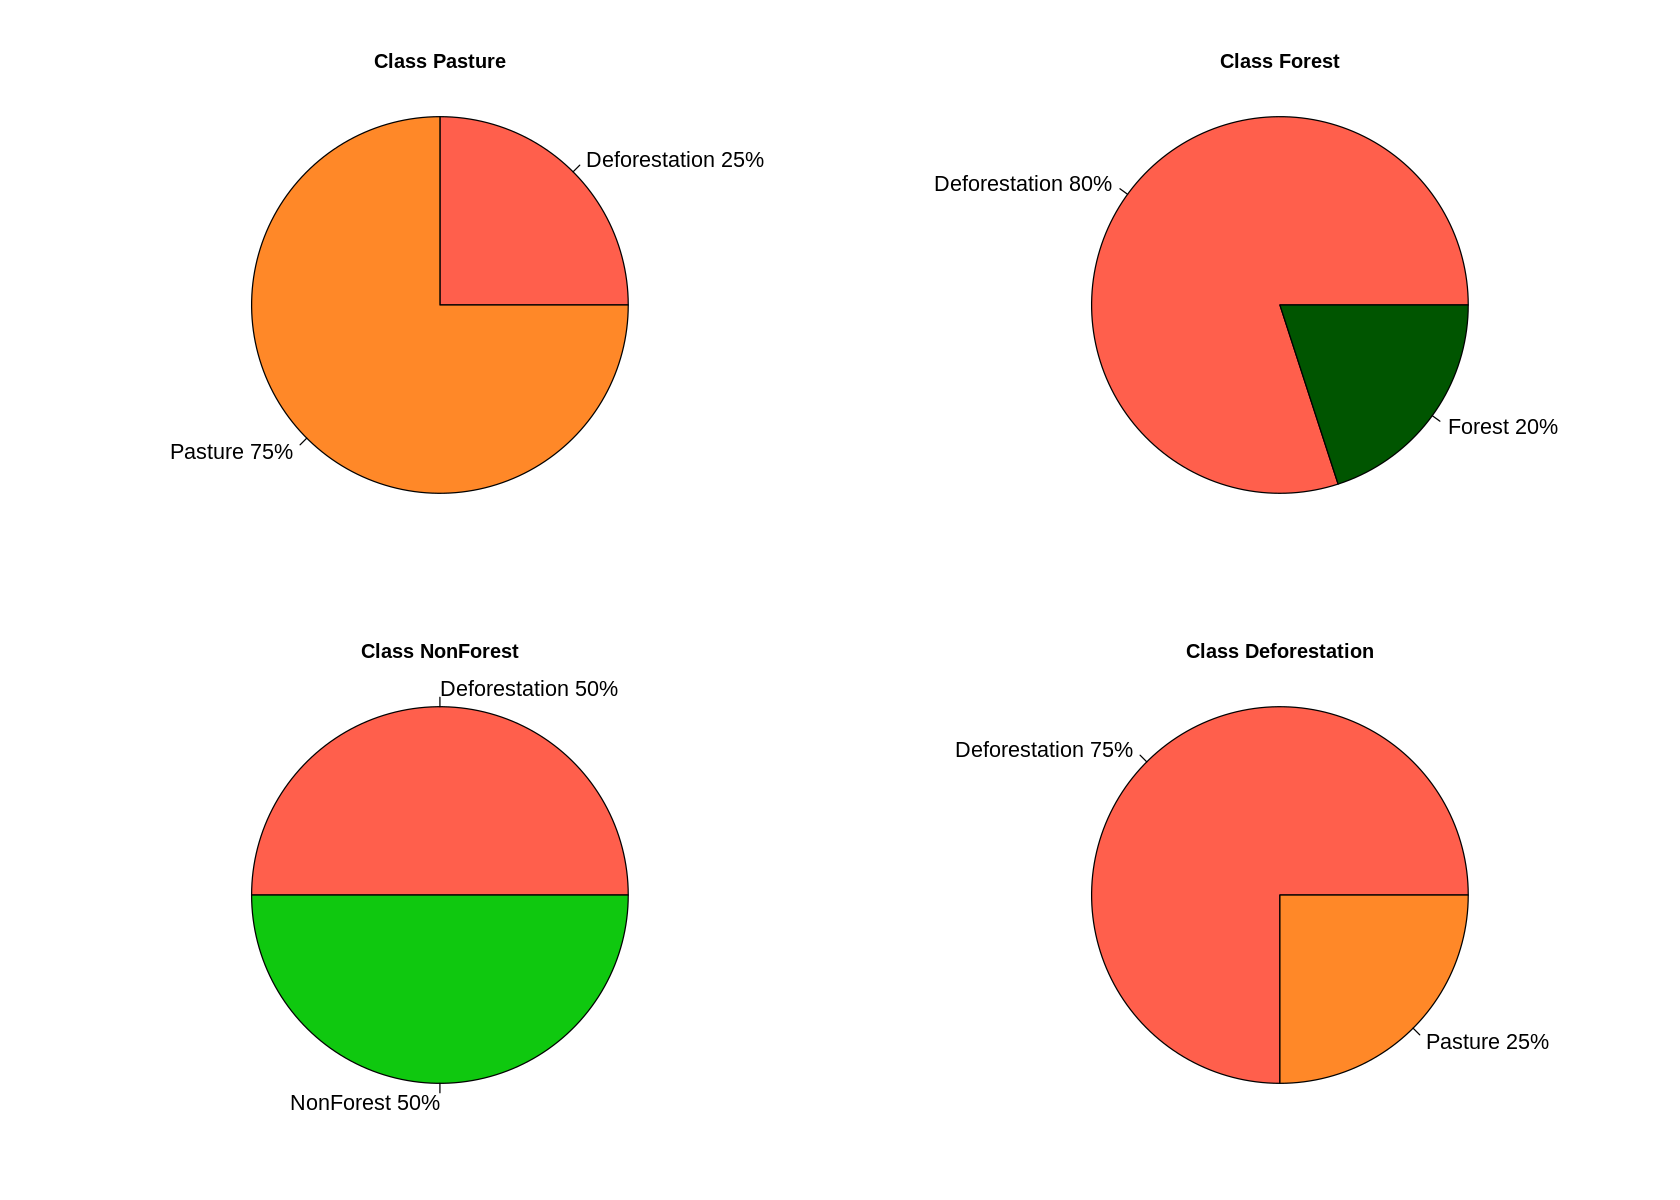

In [136]:
options(repr.plot.width = 14, repr.plot.height = 10)
par(mfrow = c(2,2), oma = c(0,0,1,0), tck = 0)
confusion <- as.data.frame(results$table)
for (i in 1:length(labels_summary$label)) {
    filtered <- dplyr::filter(confusion, Reference == labels_summary[i, ]$label)
    colors <- c()
    for (i in 1:length(filtered$Prediction)) {
        label <- as.character(filtered$Prediction[[i]])
        colors <- append(colors, color.label(label))
    }
    mutation_ <- dplyr::mutate(filtered, percent = Freq/sum(Freq), color = colors)
    mutation_ <- dplyr::filter(mutation_, percent > 0)
    pie(
        mutation_$percent,
        paste(mutation_$Prediction, " ", round((mutation_$percent * 100), 1), "%", sep=""),
        col = mutation_$color,
        main = paste("Class", mutation_$Reference[[1]]),
        cex = 1.3,
        radius = 1
    )
}

box(col = "white")

In [143]:
prediction <- random_samples(prediction_, 5, "Deforestation")
dplyr::select(prediction, -time_series)

sample_id,longitude,latitude,start_date,end_date,label,cube,predicted
<int>,<dbl>,<dbl>,<date>,<date>,<chr>,<chr>,<list>
65,-64.17986,-10.405782,2018-07-28,2019-07-28,Deforestation,sentinel-077095,"17740 , 18105 , Pasture , 0.00651736371219158, 0.00718569243326783, 0.348936975002289 , 0.637360036373138"
1,-64.69448,-9.986312,2018-07-28,2019-07-28,Deforestation,sentinel-077095,"17740 , 18105 , Pasture , 0.00900223664939404, 0.00311511405743659, 0.0946641340851784 , 0.893218517303467"
1049,-65.03989,-9.989434,2018-07-28,2019-07-28,Deforestation,sentinel-077095,"17740 , 18105 , Deforestation , 0.748906135559082 , 0.0139872655272484, 0.135248452425003 , 0.101858139038086"
19,-64.71480,-10.179301,2018-07-28,2019-07-28,Deforestation,sentinel-077095,"17740 , 18105 , Pasture , 0.0273195002228022 , 0.00122196739539504, 0.00783869065344334, 0.963619768619537"
78,-64.24136,-10.484332,2018-07-28,2019-07-28,Deforestation,sentinel-077095,"17740 , 18105 , Deforestation , 0.937004029750824 , 0.0112436292693019, 0.0286729354411364, 0.0230793412774801"


In [167]:
get_metrics(prediction)

entropy,least_conf,margin_conf,ratio_conf,new_label,label
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.7227332,0.48351995,0.71157694,1.826576,Pasture,Deforestation
0.3844109,0.14237531,0.20144562,9.435659,Pasture,Deforestation
0.7795055,0.33479182,0.38634232,5.537262,Deforestation,Deforestation
0.1802681,0.04850698,0.06369973,35.272233,Pasture,Deforestation
0.3002520,0.08399463,0.09166891,32.679041,Deforestation,Deforestation


In [149]:
toy_case <- list()
for (i in 1:length(prediction$predicted)) {
    probs <- as.data.frame(as.data.frame(prediction[i, ]$predicted)$probs)
    tryCatch(
        expr = {
            toy_case[["sample_id"]] <- append(toy_case[["sample_id"]], prediction[i, ]$sample_id)
            toy_case[["True_Label"]] <- append(toy_case[["True_Label"]], prediction[i, ]$label)
            toy_case[["Predicition"]] <- append(toy_case[["Predicition"]], as.data.frame(prediction[i, ]$predicted)$class)
        },
        error = function(e){
            toy_case[["sample_id"]] <- c()
            toy_case[["sample_id"]] <- append(toy_case[["sample_id"]], prediction[i, ]$sample_id)
            toy_case[["True_Label"]] <- c()
            toy_case[["True_Label"]] <- append(toy_case[["True_Label"]], prediction[i, ]$label)
            toy_case[["Prediction"]] <- c()
            toy_case[["Prediction"]] <- append(toy_case[["Prediction"]], as.data.frame(prediction[i, ]$predicted)$class)
        }
    )
    for (label in labels_summary$label) {
        tryCatch(
            expr = {
                toy_case[[label]] <- append(toy_case[[label]], probs[[label]])
            },
            error = function(e){ 
                toy_case[[label]] <- c()
                toy_case[[label]] <- append(toy_case[[label]], probs[[label]])
            }
        )
    }
}
toy_case <- as.data.frame(toy_case)
toy_case

sample_id,True_Label,Predicition,Pasture,Forest,NonForest,Deforestation
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
65,Deforestation,Pasture,0.63736004,0.007185692,0.348936975,0.006517364
1,Deforestation,Pasture,0.89321852,0.003115114,0.094664134,0.009002237
1049,Deforestation,Deforestation,0.10185814,0.013987266,0.135248452,0.748906136
19,Deforestation,Pasture,0.96361977,0.001221967,0.007838691,0.027319500
78,Deforestation,Deforestation,0.02307934,0.011243629,0.028672935,0.937004030


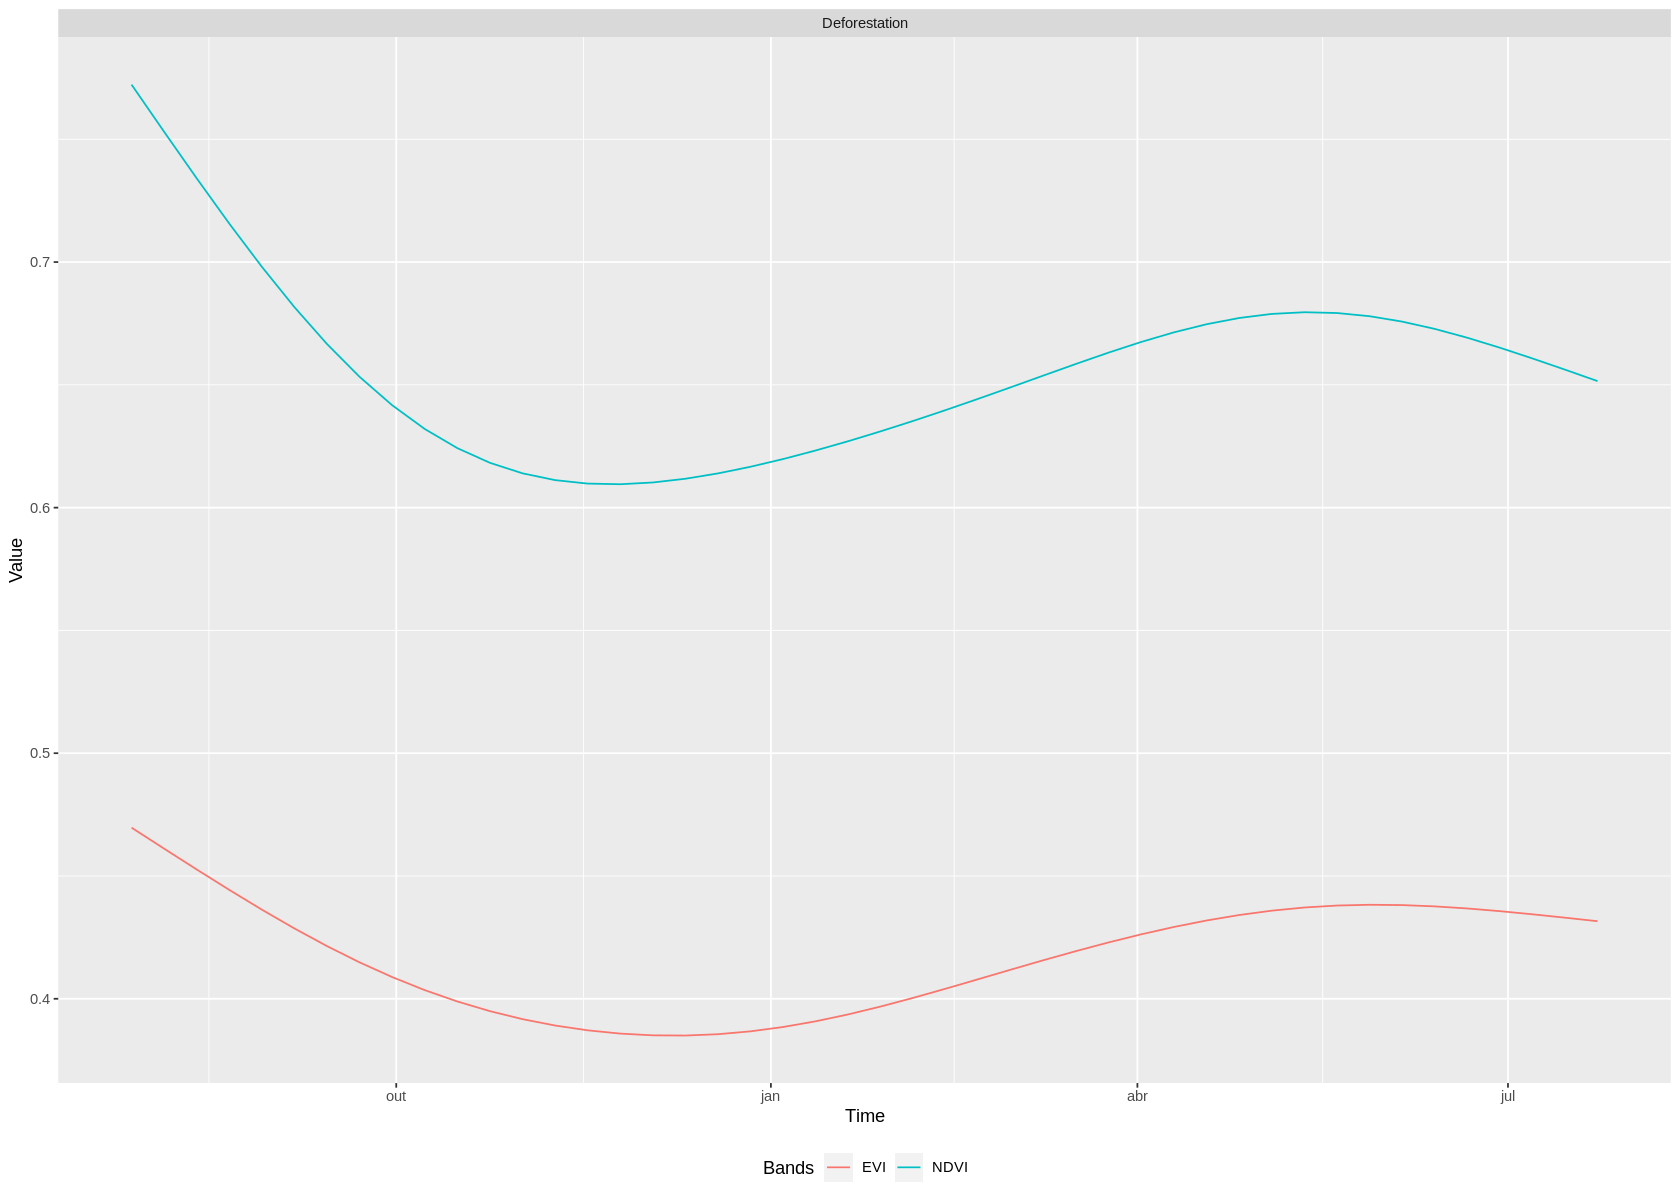

In [166]:
options(repr.plot.width = 14, repr.plot.height = 10)
test_case <- dplyr::filter(test_, (sample_id %in% toy_case$sample_id))
plot(test_case %>% sits_select(bands = c("NDVI", "EVI")) %>% sits_patterns())

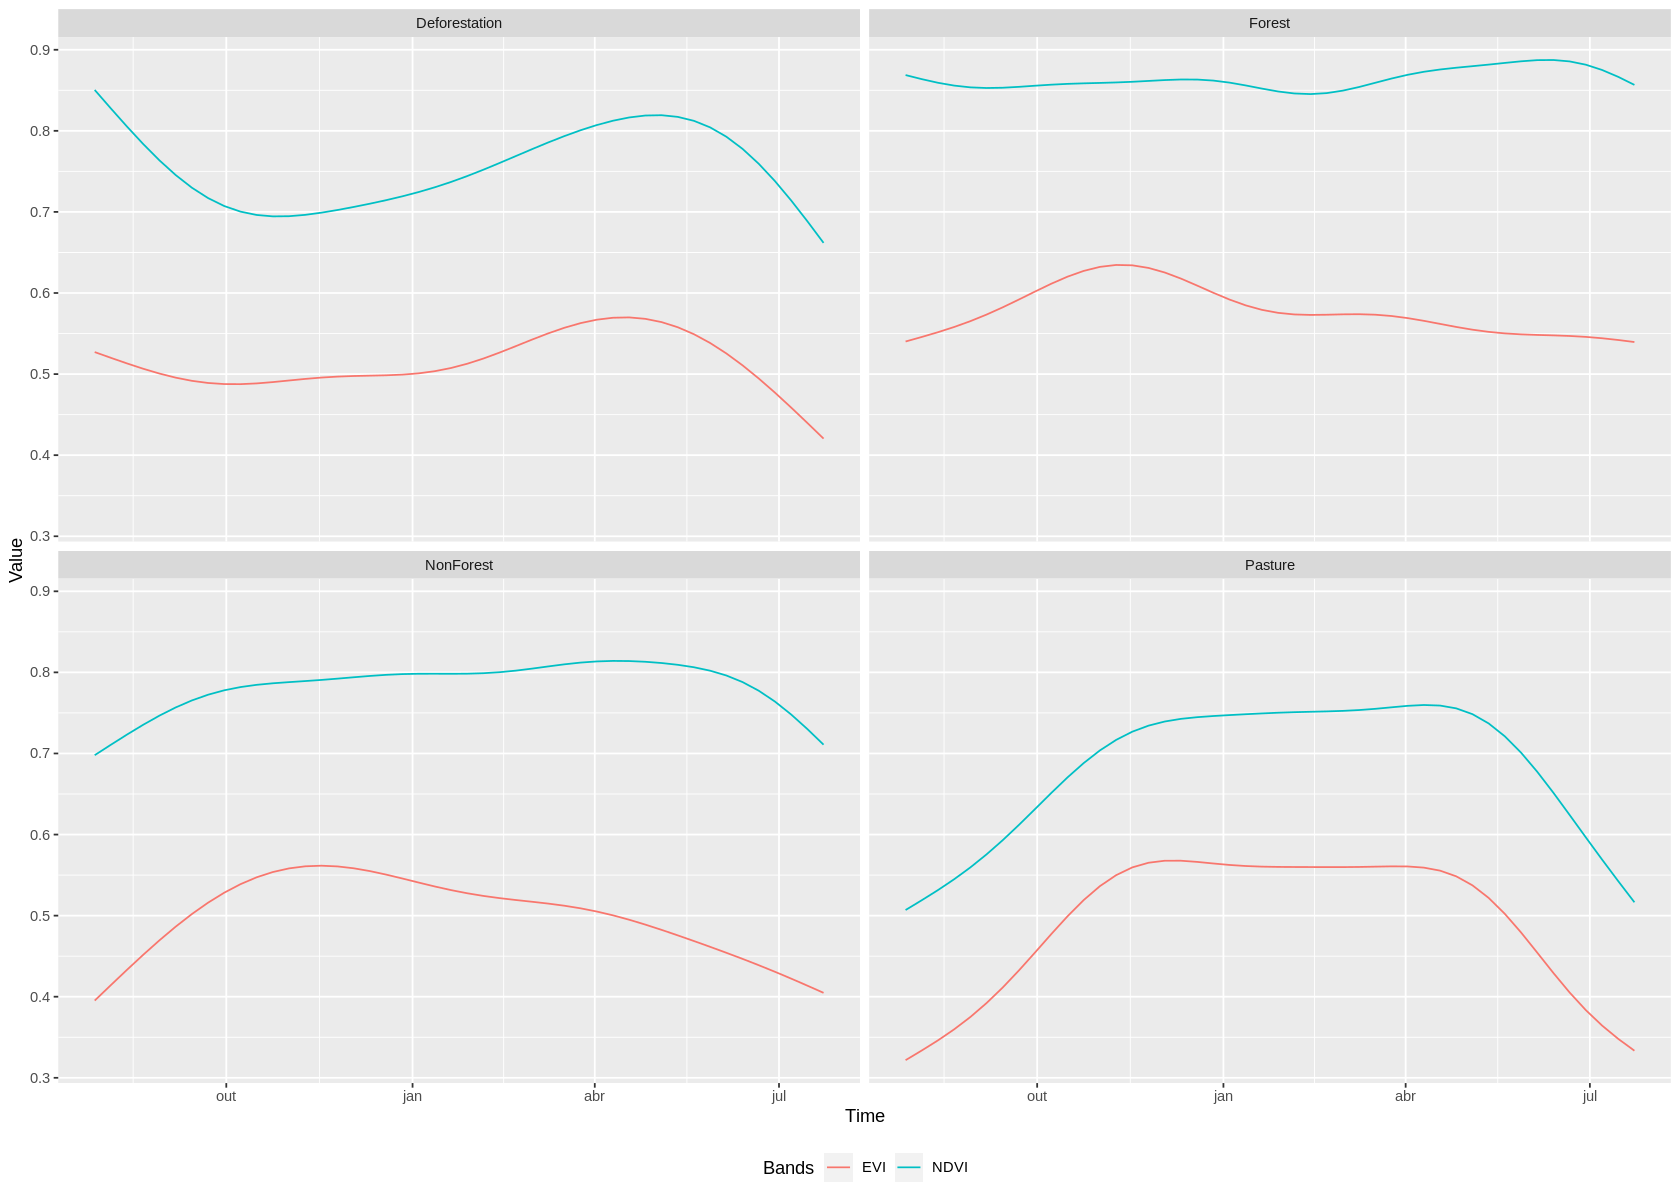

In [152]:
options(repr.plot.width = 14, repr.plot.height = 10)
plot(samples %>% sits_select(bands = c("NDVI", "EVI")) %>% sits_patterns())

In [155]:
labels <- labels_summary$label
metrics <- get_accuracy_metrics(results)
labels <- labels_summary$label
n_iteration <- 1
overall_accuracy <- dplyr::filter(metrics, metric == "accuracy")$accuracy[[1]]
metrics_tb <- list()
for (i in 1:length(labels)) {
    data_ <- dplyr::filter(metrics, class == labels[i])
    tryCatch(
        expr = {
            metrics_tb[["Label"]] <- append(metrics_tb[["Label"]], labels[[i]])
            
            score <- dplyr::filter(data_, metric == "f1_score")
            metrics_tb[["F1_Score"]] <- append(metrics_tb[["F1_Score"]], score$accuracy[[1]])
            
            score <- dplyr::filter(data_, metric == "user_acc")
            metrics_tb[["User_Accuracy"]] <- append(metrics_tb[["User_Accuracy"]], score$accuracy[[1]])
            
            score <- dplyr::filter(data_, metric == "prod_acc")
            metrics_tb[["Productor_Accuracy"]] <- append(metrics_tb[["Productor_Accuracy"]], score$accuracy[[1]])
        },
        error = function(e){
            metrics_tb[["Label"]] <- c()
            metrics_tb[["Label"]] <- append(metrics_tb[["Label"]], labels[i])
            
            metrics_tb[["F1_Score"]] <- c()
            score <- dplyr::filter(data_, metric == "f1_score")
            metrics_tb[["F1_Score"]] <- append(metrics_tb[["F1_Score"]], score$accuracy[[1]])
            
            metrics_tb[["User_Accuracy"]] <- c()
            score <- dplyr::filter(data_, metric == "user_acc")
            metrics_tb[["User_Accuracy"]] <- append(metrics_tb[["User_Accuracy"]], score$accuracy[[1]])
            
            metrics_tb[["Productor_Accuracy"]] <- c()
            score <- dplyr::filter(data_, metric == "prod_acc")
            metrics_tb[["Productor_Accuracy"]] <- append(metrics_tb[["Productor_Accuracy"]], score$accuracy[[1]])
        }
    )
}
metrics_tb <- as.data.frame(metrics_tb)
rownames(metrics_tb) <- metrics_tb$Label
metrics_tb <- dplyr::select(metrics_tb, -Label)
metrics_tb

,F1_Score,User_Accuracy,Productor_Accuracy
,<dbl>,<dbl>,<dbl>
Pasture,0.7500000,0.75,0.7500000
Forest,0.3333333,0.20,1.0000000
NonForest,0.6666667,0.50,1.0000000
Deforestation,0.3529412,0.75,0.2307692


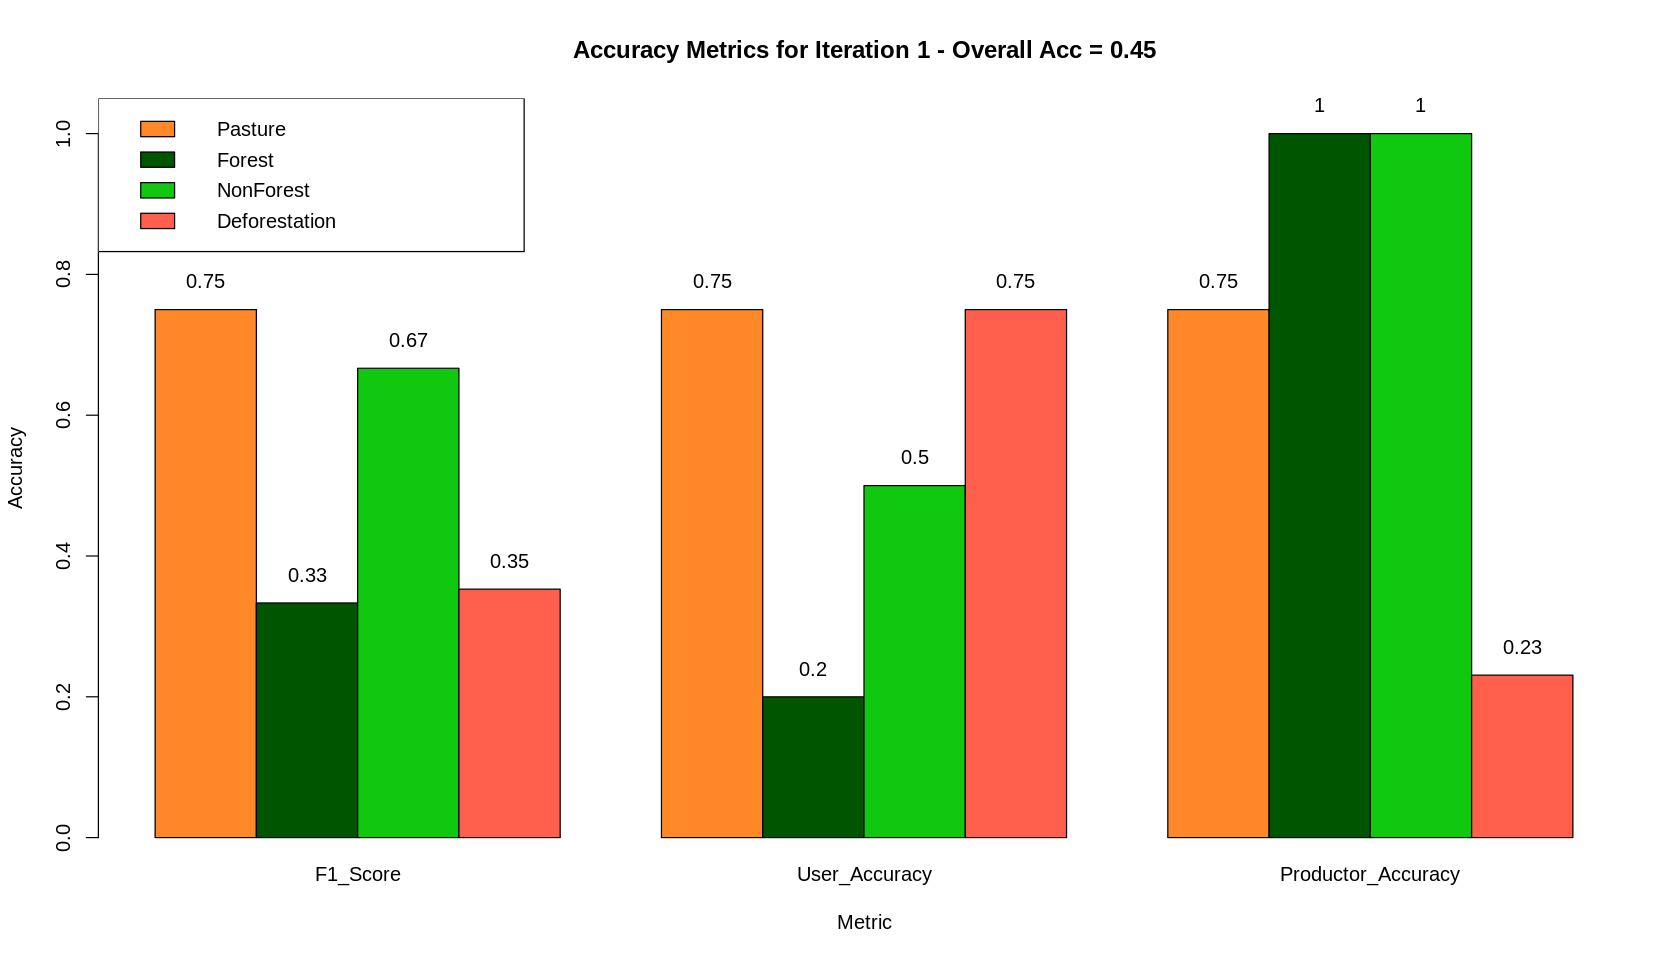

In [156]:
# This data is plotted as follows.
options(repr.plot.width = 14, repr.plot.height = 8)
data_ <- as.matrix(metrics_tb)
barp <- barplot(
    data_,
    main = paste(
        "Accuracy Metrics for Iteration", n_iteration, "-",
        paste("Overall Acc =", round(overall_accuracy, 2))
    ),
    xlab = "Metric",
    ylab = "Accuracy",
    col = labels_summary$color,
    ylim = c(0, 1.05),
    beside = TRUE
)
text(barp, data_ + 0.04, labels = round(data_, 2))
legend(
    "topleft",
    labels_summary$label,
    fill = labels_summary$color
)

In [173]:
# Initial number of labels to be taken from each label.
n_labelled <- 4
labelled_samples <- random_samples_per_class(samples, n_labelled)
labelled_samples %>% dplyr::select(-time_series)

sample_id,longitude,latitude,start_date,end_date,label,cube
<int>,<dbl>,<dbl>,<date>,<date>,<chr>,<chr>
15,-64.46717,-10.155378,2018-07-28,2019-07-28,Deforestation,sentinel-077095
786,-64.90963,-9.982432,2018-07-28,2019-07-28,Deforestation,sentinel-077095
88,-64.14913,-10.522683,2018-07-28,2019-07-28,Deforestation,sentinel-077095
973,-65.08695,-10.090197,2018-07-28,2019-07-28,Deforestation,sentinel-077095
350,-63.91053,-10.942386,2018-07-28,2019-07-28,Forest,sentinel-077095
1059,-65.09891,-10.825503,2018-07-28,2019-07-28,Forest,sentinel-077095
372,-64.45987,-10.892040,2018-07-28,2019-07-28,Forest,sentinel-077095
115,-64.62651,-10.194377,2018-07-28,2019-07-28,Forest,sentinel-077095
993,-65.10750,-10.745906,2018-07-28,2019-07-28,NonForest,sentinel-077095


In [174]:
shape <- point_to_shape_sp(data.tb = labelled_samples)
leaflet(shape, options = leafletOptions(minZoom = 0, maxZoom = 100)) %>%
    addProviderTiles('Esri.WorldImagery') %>%
        addRectangles(
            lng1 = bbox_shape$longitude[[1]], bbox_shape$latitude[[1]],
            lng2 = bbox_shape$longitude[[2]], bbox_shape$latitude[[2]],
            fillColor = "transparent",
            popup = "Bounding Box") %>%
            addCircleMarkers(
                ~longitude, ~latitude,
                fillOpacity = 1,
                fillColor = ~color,
                stroke = F,
                radius = 5,
                popup = ~as.character(
                    paste("Class '", label,
                          "' #id", sample_id, "|",
                          format(
                              as.Date(start_date),
                              format = "Start %Y-%m-%d"
                          ),
                          format(
                              as.Date(end_date),
                              format = "End %Y-%m-%d"
                          )
                )))

Error : Problem with `filter()` input `..1`.
ℹ Input `..1` is `(as.Date(start_date) <= as.Date(date)) & (as.Date(date) <= as.Date(end_date))`.
✖ argument "date" is missing, with no default
Error : Can't subset columns that don't exist.
✖ Column `id_neuron` doesn't exist.
Error : Problem with `filter()` input `..1`.
ℹ Input `..1` is `label == class_label`.
✖ argument "class_label" is missing, with no default


HTML widgets cannot be represented in plain text (need html)

In [175]:
iteration <- function(training_samples, samples_tb, sits_method, reference_labels) {
    
    classification_model  <- sits::sits_train(training_samples, ml_method = sits_method)
    
    prediction_fct <- samples_tb %>% 
        dplyr::filter(!(sample_id %in% training_samples$sample_id)) %>%
            sits::sits_classify(ml_model = classification_model) %>% 
                dplyr::pull(predicted) %>%
                    purrr::map_chr(magrittr::extract("class")) %>%
                        factor(levels = reference_labels)
    
    reference_fct <- samples_tb %>%
        dplyr::filter(!(sample_id %in% training_samples$sample_id)) %>%
            pull(label) %>% 
                factor(levels = reference_labels)
    
    return(
        caret::confusionMatrix(data = prediction_fct, reference = reference_fct) %>%
            get_accuracy_metrics() %>% 
                dplyr::mutate(n_samples = nrow(training_samples))
    )
}

In [176]:
experiment <- function(x, labelled_samples, n_samples, sits_method){

    #---- Test without active learning ----
    training_samples <- labelled_samples
    for (i in 1:n_iterations) {
    
        new_samples <- samples_tb %>% 
            dplyr::filter(!(sample_id %in% training_samples$sample_id)) %>% 
                dplyr::sample_n(size = n_samples)
    
        training_samples <- training_samples %>% 
            dplyr::bind_rows(new_samples) %>% 
                magrittr::set_class(class(sits::cerrado_2classes))
     
        acc_iter <- iteration(training_samples, samples_tb, sits_method, reference_labels) %>% 
            dplyr::mutate(type = "Without AL", iteration = i)
    
        accuracy_tb <- accuracy_tb %>% 
            dplyr::bind_rows(acc_iter)
    }
    
    #---- Test using AL random sampling ----
    training_samples <- labelled_samples %>% 
        magrittr::set_class(class(sits::cerrado_2classes))
    for (i in 1:n_iterations) {
        
        unlabelled_tb <- samples_tb %>% 
            dplyr::filter(!(sample_id %in% training_samples$sample_id)) %>% 
                dplyr::mutate(label = NA)
  
        # Use AL random sampling to choose the samples to be sent to the oracle. 
        oracle_samples <- training_samples %>% 
            dplyr::bind_rows(unlabelled_tb) %>% 
                al_random_sampling(sits_method = sits_method, multicores = 1) %>% 
                    dplyr::filter(sample_id %in% unlabelled_tb$sample_id) %>% 
                        dplyr::arrange(dplyr::desc(entropy)) %>% 
                            dplyr::slice_head(n = n_samples) %>% 
                                dplyr::select(-entropy, -least_conf, -margin_conf, -ratio_conf, -new_label)
    
        # Get the true labels from the oracle
        oracle_samples <- oracle_samples %>% 
            dplyr::left_join(y = samples_tb %>% 
                dplyr::filter(!(sample_id %in% training_samples$sample_id)) %>% 
                    dplyr::select(true_label = label, sample_id), by = "sample_id") %>% 
                        dplyr::mutate(label = true_label) %>%
                              dplyr::select(-true_label)
                    
        # Add the oracle samples to the training set.
        training_samples <- training_samples %>% 
            dplyr::bind_rows(oracle_samples) %>% 
                magrittr::set_class(class(sits::cerrado_2classes))
    
        # Do the classification and estimate the accuracy.
        acc_iter <- iteration(training_samples, samples_tb, sits_method, reference_labels) %>% 
            dplyr::mutate(type = "AL Random Sampling", iteration = i)
    
        accuracy_tb <- accuracy_tb %>% 
            dplyr::bind_rows(acc_iter)
    }
    
    return(
        accuracy_tb %>% 
            dplyr::mutate(experiment = x)
    )
}

In [198]:
# Number of iterations
n_iterations <- 5
# Number of experiments
n_experiments <- 10
# Number of labels to be selected on each iteration.
n_samples <- length(labels_summary$label) * n_labelled
# data to be used
samples_tb <- test_
# Labels
reference_labels <- labels_summary$label
# Cores
cores <- parallel::detectCores() / 2
# Accuracy History
accuracy_tb <- tibble::tibble()

In [202]:
accuracy_lst <- parallel::mclapply(
    1:3,
    experiment, 
    labelled_samples = labelled_samples, 
    n_samples = n_samples,
    sits_method = sits_method,
    mc.cores = cores
)

In [203]:
save_file.tb(accuracy_lst, "./data/output/accuracy_lst", "rda")

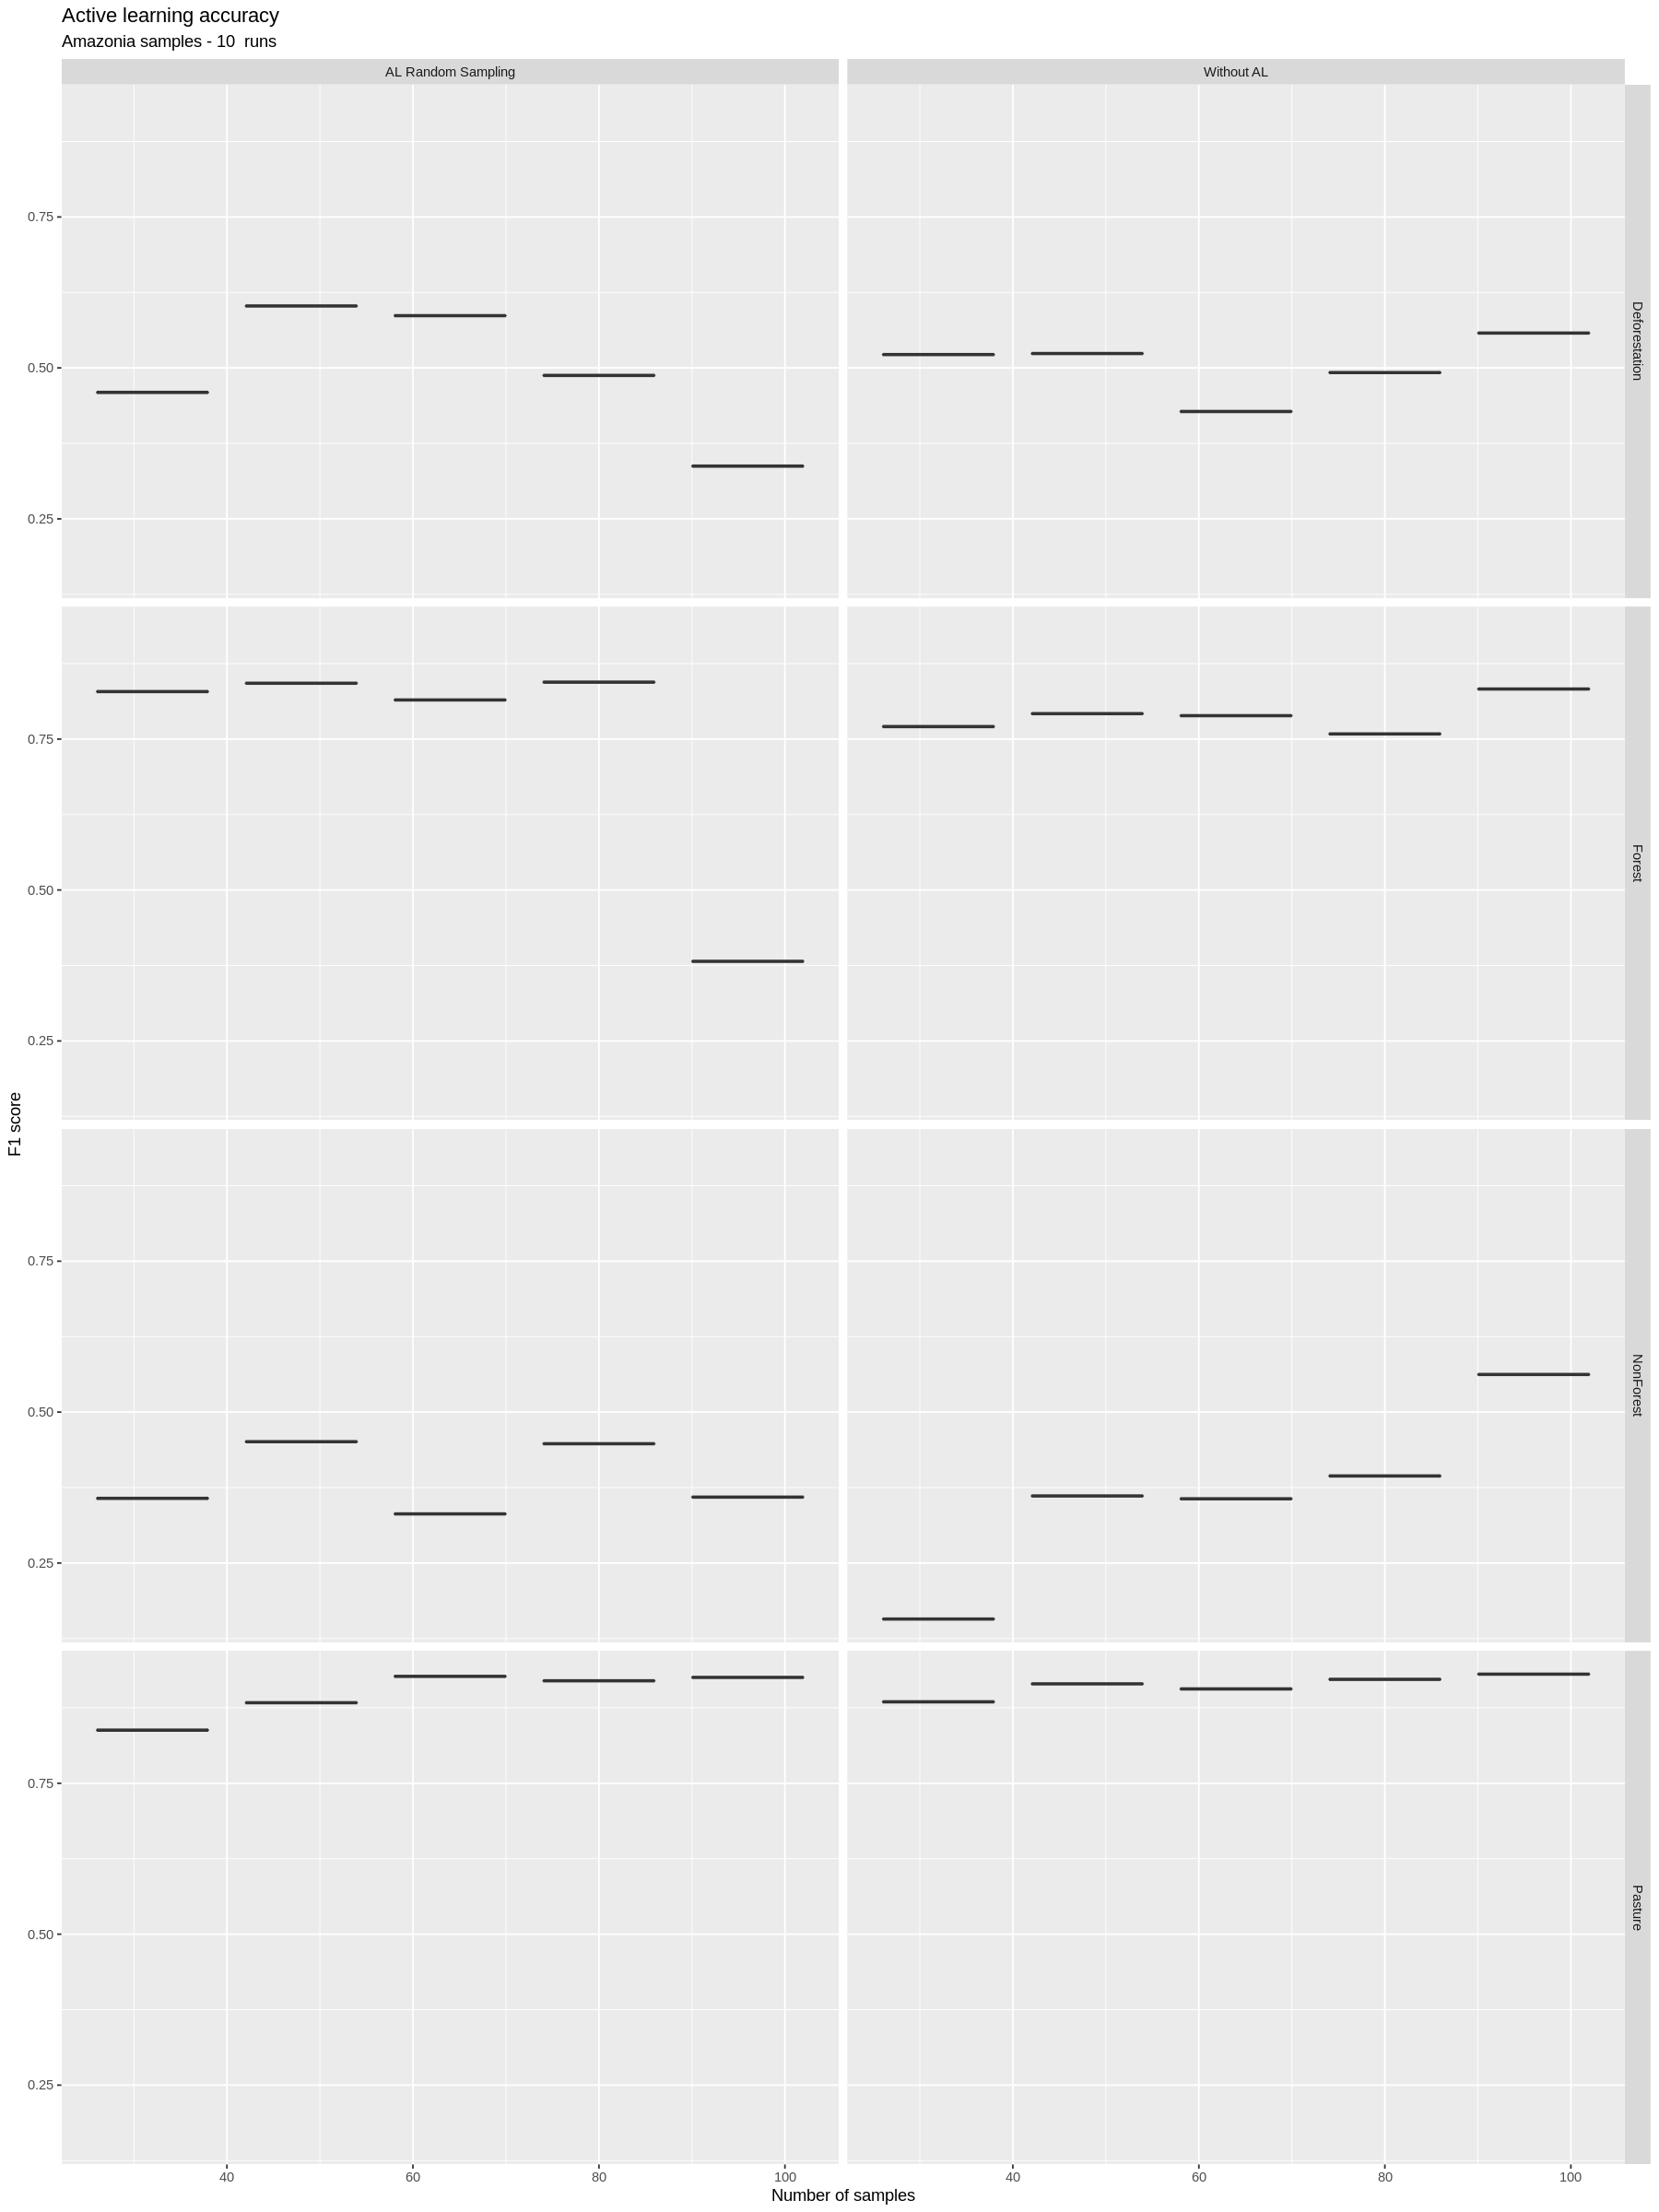

In [205]:
options(repr.plot.width = 15, repr.plot.height = 20)
accuracy_lst %>% 
    dplyr::bind_rows() %>% 
        dplyr::filter(metric == "f1_score") %>%
            ggplot2::ggplot() + 
            ggplot2::geom_boxplot(ggplot2::aes(x = n_samples, y = accuracy, group = n_samples)) +
            ggplot2::facet_grid(cols = dplyr::vars(type), rows = dplyr::vars(class)) +
            ggplot2::labs(title = "Active learning accuracy", subtitle = paste("Amazonia samples", paste(n_experiments, " runs"), sep = " - ")) +
            ggplot2::xlab("Number of samples") + 
            ggplot2::ylab("F1 score")

ggplot2::ggsave(filename = "./data/output/comparison_deforestation.png", width = 297, height = 210, units = "mm")